In [1]:
# Importing libraries...
import math
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

training_dir = "/Users/sidharthagarwal/Desktop/assignments/ml774/Assignment2/Q1/part1_data/train" #str(sys.argv[1])
testing_dir  = "/Users/sidharthagarwal/Desktop/assignments/ml774/Assignment2/Q1/part1_data/test"  #str(sys.argv[2])

In [2]:
# Initializing variables..

def restartModel():
    wordFreq = {}
    wordFreq[0] = {}
    wordFreq[1] = {}

    totalFreq = {}
    totalFreq[0] = 0
    totalFreq[1] = 0

    totalDocs = {}
    totalDocs[0] = 0
    totalDocs[1] = 1

    alpha = 1
    posCloudText = ""
    negCloudText = ""

    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    vocabulary = 0
    
    return wordFreq,totalFreq,totalDocs,alpha,posCloudText,negCloudText,TP,FP,TN,FN,vocabulary

wordFreq,totalFreq,totalDocs,alpha,posCloudText,negCloudText,TP,FP,TN,FN,vocabulary = restartModel()

def resultAnalysis(TP,FP,TN,FN):
    prec = TP/(TP+FP)
    rec  = TP/(TP+FN)
    print("The precision is : "+str(prec))
    print("The recall is : "+str(rec))
    print("The F1 score is : "+str((2*prec*rec)/(prec+rec)))

In [3]:
# Training the model
def trainModel(path,label,wordFreq,totalFreq,totalDocs,preprocessing = False,featuring = False):
    
    listOfFiles = os.listdir(path)
    for fileName in listOfFiles:
        
        file = open(os.path.join(path,fileName),"r")
        text = file.read()
        word_list = re.split(' |,|\\.|\n|:|;|"|\'|`|{{|}}|[|]|\)|\(',text)
        
        new_word_list = []
        for word in word_list:
            
            if preprocessing:
                word = ps.stem(word.lower())
                if word in stop_words:
                    continue
                
            if word not in wordFreq[label]:
                wordFreq[label][word] = 0
                
            wordFreq[label][word] += 1
            totalFreq[label] += 1
            new_word_list.append(word)
        
        if featuring:
            prevWord = new_word_list[0]
            for word in new_word_list[1:]:
                bigram = prevWord + " " + word
                prevWord = word
                
                if bigram not in wordFreq[label]:
                    wordFreq[label][bigram] = 0
                
                wordFreq[label][bigram]  += 1
                totalFreq[label] += 1
        
    totalDocs[label] += len(listOfFiles)

trainModel(training_dir+"/pos",1,wordFreq,totalFreq,totalDocs)
trainModel(training_dir+"/neg",0,wordFreq,totalFreq,totalDocs)    

In [4]:
# Testing the model

def predictLabel(path,wordFreq,totalFreq,totalDocs,isPosCloud,preprocessing,featuring):
    global posCloudText
    global negCloudText
    
    file = open(path,"r")
    text = file.read()
    word_list = re.split(' |,|\\.|\n|:|;|"|\'|`|{{|}}|[|]|\)|\(',text)
    
    positive_prob = 0
    negative_prob = 0
    
    new_word_list = []
    for word in word_list:
        
        if preprocessing:
            word = ps.stem(word.lower())
            if word in stop_words:
                continue
        
        if isPosCloud and len(posCloudText)<10000:
            posCloudText += word + " "
        elif not isPosCloud and len(negCloudText)<10000:
            negCloudText += word + " "
        
        posFreq = alpha if word not in wordFreq[1] else wordFreq[1][word] + alpha
        negFreq = alpha if word not in wordFreq[0] else wordFreq[0][word] + alpha
        
        positive_prob += math.log(posFreq) - math.log(totalFreq[1] + alpha*vocabulary)
        negative_prob += math.log(negFreq) - math.log(totalFreq[0] + alpha*vocabulary)
        
        new_word_list.append(word)
    
    if featuring:
        prevWord = new_word_list[0]
        for word in new_word_list[1:]:
            bigram = prevWord + " "+ word
            
            posFreq = alpha if bigram not in wordFreq[1] else wordFreq[1][bigram] + alpha
            negFreq = alpha if bigram not in wordFreq[0] else wordFreq[0][bigram] + alpha
            
            positive_prob += math.log(posFreq) - math.log(totalFreq[1] + alpha*vocabulary)
            negative_prob += math.log(negFreq) - math.log(totalFreq[0] + alpha*vocabulary)
            
    positive_prob +=  -1*math.log(totalDocs[0])
    negative_prob +=  -1*math.log(totalDocs[1])
    
    if positive_prob>=negative_prob:
        return 1
    return 0
        
    
def prediction(path,wordFreq,totalFreq,totalDocs,preprocessing = False,featuring = False):
    global TP,TN,FP,FN
    correct = 0
    total = 0
    
    pos_path = path + "/pos"
    listOfPos = os.listdir(pos_path)
    for fileName in listOfPos:
        thisLabel = predictLabel(os.path.join(pos_path,fileName),wordFreq,totalFreq,totalDocs,True,preprocessing,featuring)
        if(thisLabel==1):
            correct += 1
            TP += 1
        else:
            FN += 1
    total += len(listOfPos)
    
    neg_path = path + "/neg"
    listOfNeg = os.listdir(neg_path)
    for fileName in listOfNeg:
        thisLabel = predictLabel(os.path.join(neg_path,fileName),wordFreq,totalFreq,totalDocs,False,preprocessing,featuring)
        if(thisLabel==0):
            correct += 1
            TN += 1
        else:
            FP += 1
    total += len(listOfNeg)
    
    print("The accuracy is : "+str(correct/total))

vocabulary = len(set(list(wordFreq[0].keys()) + list(wordFreq[1].keys())))
print("For training dataset: ")
prediction(training_dir,wordFreq,totalFreq,totalDocs)
print("For testing dataset: ")
prediction(testing_dir,wordFreq,totalFreq,totalDocs)


For training dataset: 
The accuracy is : 0.91628
For testing dataset: 
The accuracy is : 0.7974


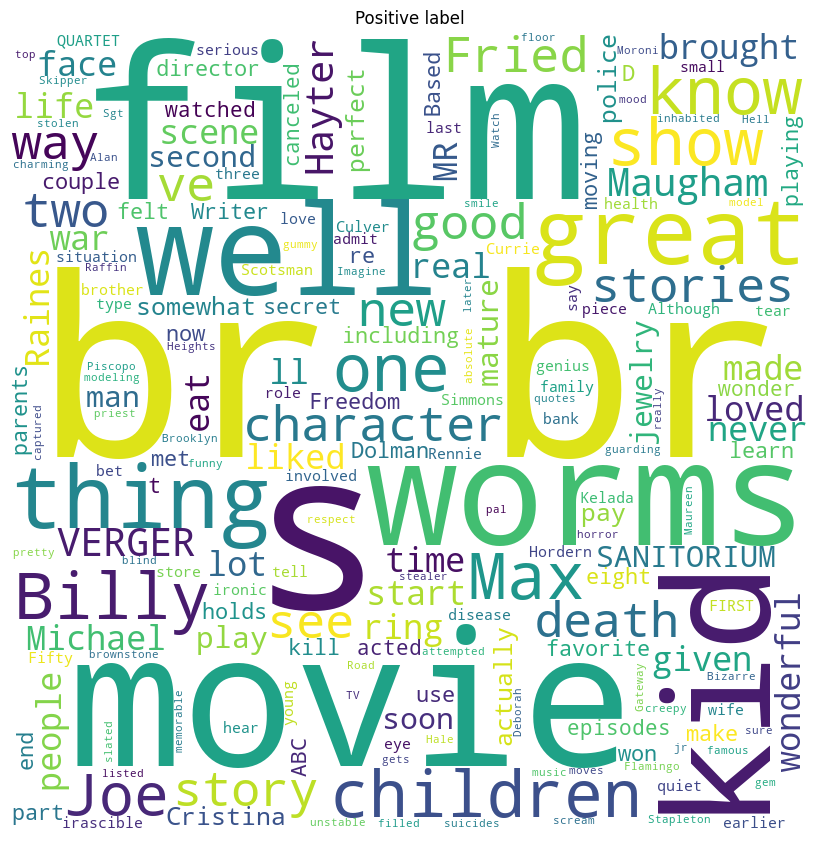

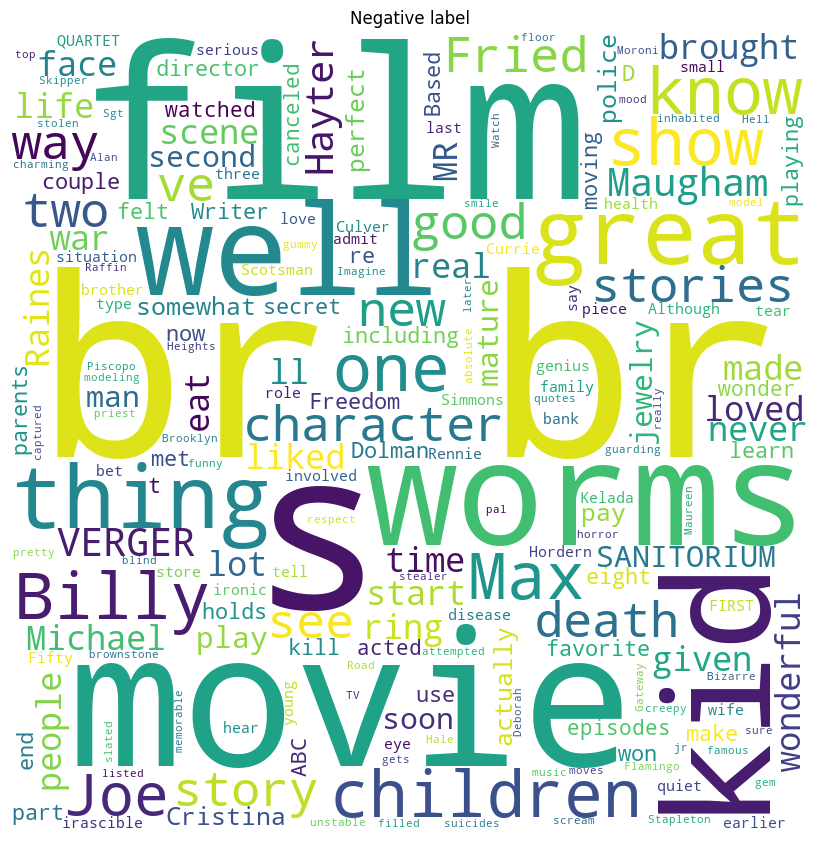

In [5]:
# wordclouds

wordcloud = WordCloud(width = 800, height = 800, background_color ='white',stopwords = set(STOPWORDS),
          min_font_size = 10).generate(posCloudText)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Positive label")
 
plt.show()

wordlcoud = WordCloud(width = 800, height = 800, background_color ='white',stopwords = set(STOPWORDS),
          min_font_size = 10).generate(negCloudText)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Negative label")

plt.show()


In [6]:
# Qb

totalPosB = len(os.listdir(testing_dir + "/pos"))
totalNegB = len(os.listdir(testing_dir + "/neg"))

print("For b.i the accuracy will be : 0.5")
print("For b.ii the accuracy will be : "+str(totalPosB/(totalPosB+totalNegB)))

For b.i the accuracy will be : 0.5
For b.ii the accuracy will be : 0.6666666666666666


In [7]:
# Qc

def printConfusion(TP,FP,TN,FN):
    confDict = {"1":[TP,FN],"0":[FP,TN]}
    df = pd.DataFrame(confDict)
    df.index = ["1","0"]
    print(df)

print("For part a: ")
printConfusion(TP,FP,TN,FN)

print("\nFor part b random: ")
printConfusion(totalPosB/2,totalPosB/2,totalNegB/2,totalNegB/2)

print("\nFor part b only positive: ")
printConfusion(totalPosB,totalNegB,0,0)

For part a: 
       1      0
1  18667   1299
0   3833  16201

For part b random: 
        1       0
1  5000.0  5000.0
0  2500.0  2500.0

For part b only positive: 
       1     0
1  10000  5000
0      0     0


In [8]:
#Qd

print("For part a: ")
resultAnalysis(TP,FP,TN,FN)

restartModel()
trainModel(training_dir+"/pos",1,wordFreq,totalFreq,totalDocs,True)
trainModel(training_dir+"/neg",0,wordFreq,totalFreq,totalDocs,True)

vocabulary = len(set(list(wordFreq[0].keys()) + list(wordFreq[1].keys())))
print("\n\nFor part d: ")
print("Accuracy For training dataset: ")
prediction(training_dir,wordFreq,totalFreq,totalDocs,True)
print("Accuracy For testing dataset: ")
prediction(testing_dir,wordFreq,totalFreq,totalDocs,True)

print("For part d: ")
resultAnalysis(TP,FP,TN,FN)

For part a: 
The precision is : 0.9349393969748573
The recall is : 0.8296444444444444
The F1 score is : 0.8791503791268308


For part d: 
Accuracy For training dataset: 
The accuracy is : 0.91732
Accuracy For testing dataset: 
The accuracy is : 0.8056666666666666
For part d: 
The precision is : 0.9344458281444583
The recall is : 0.8337333333333333
The F1 score is : 0.8812213740458016


In [ ]:
# Qe

restartModel()
trainModel(training_dir+"/pos",1,wordFreq,totalFreq,totalDocs,True,True)
trainModel(training_dir+"/neg",0,wordFreq,totalFreq,totalDocs,True,True)

vocabulary = len(set(list(wordFreq[0].keys()) + list(wordFreq[1].keys())))
print("\n\nFor part e: ")
print("Accuracy For training dataset: ")
prediction(training_dir,wordFreq,totalFreq,totalDocs,True,True)
print("Accuracy For testing dataset: ")
prediction(testing_dir,wordFreq,totalFreq,totalDocs,True,True)

print("For part e: ")
resultAnalysis(TP,FP,TN,FN)




For part e: 
Accuracy For training dataset: 


In [ ]:
# Qf
#def resultAnalysis(TP,FP,TN,FN):
#    prec = TP/(TP+FP)
#    rec  = TP/(TP+FN)
#    print("The precision is : "+str(prev))
#    print("The recall is : "+str(rec))
#    print("The F1 score is : "+str((2*prec*rec)/(prec+rec)))